In [1]:
# import os
# import librosa
# import librosa.display
# import numpy as np
# import matplotlib.pyplot as plt

# def process_audio_files_in_batches(audio_dir, save_dir, img_size=(128, 128), batch_size=10, max_files_per_class=500):
#     """
#     Process .wav files in batches, convert them to mel spectrogram images, and save them in class-specific folders.
#     """
#     if not os.path.exists(save_dir):
#         os.makedirs(save_dir)
    
#     file_count = {}
#     batch = []
    
#     for root, dirs, files in os.walk(audio_dir):
#         class_name = os.path.basename(root)
#         if class_name not in file_count:
#             file_count[class_name] = 0
        
#         for file in files:
#             if file.endswith('.wav') and file_count[class_name] < max_files_per_class:
#                 file_path = os.path.join(root, file)
#                 batch.append(file_path)
#                 file_count[class_name] += 1

#                 if len(batch) == batch_size:
#                     process_batch(batch, root, save_dir, img_size)
#                     batch = []  # Clear batch after processing

#         # If batch size is not reached but class limit is reached, process the batch
#         if batch and file_count[class_name] >= max_files_per_class:
#             process_batch(batch, root, save_dir, img_size)
#             batch = []

#     # Process any remaining files
#     if batch:
#         process_batch(batch, root, save_dir, img_size)

# def process_batch(batch, root, save_dir, img_size):
#     """
#     Convert a batch of audio files to mel spectrogram images and save them.
#     """
#     for file_path in batch:
#         class_name = os.path.basename(root)
#         class_save_dir = os.path.join(save_dir, class_name)

#         if not os.path.exists(class_save_dir):
#             os.makedirs(class_save_dir)

#         # Load audio file and handle short audio files
#         y, sr = librosa.load(file_path, sr=None)
#         n_fft = min(2048, len(y))  # Adjust n_fft based on the length of the audio signal

#         # Dynamically adjust fmax to be lower than half of the sampling rate (Nyquist frequency)
#         fmax = min(8000, sr / 2)

#         mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=img_size[0], fmax=fmax, n_fft=n_fft)
#         mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

#         # Plot and save the mel spectrogram
#         plt.figure(figsize=(img_size[0]/100, img_size[1]/100))
#         librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
#         plt.axis('off')

#         save_path = os.path.join(class_save_dir, os.path.basename(file_path).replace('.wav', '.png'))
#         plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
#         plt.close()

# # Parameters
# audio_dir = '/mnt/c/Users/baldo/OneDrive - MSFT/Desktop/SIH 24/Audio MNIST/sort_data'
# save_dir = '/mnt/c/Users/baldo/OneDrive - MSFT/Desktop/SIH 24/Audio MNIST/Mel Spectrogram Dataset'
# batch_size = 20
# process_audio_files_in_batches(audio_dir, save_dir, img_size=(128, 128), batch_size=batch_size, max_files_per_class=500)

In [2]:
image_size = 32

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import librosa
import librosa.display
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
import itertools

# Function to load dataset and print class distribution
def load_and_preprocess_data(data_dir, batch_size, img_size=(128, 128)):
    train_dataset = image_dataset_from_directory(
        data_dir,
        batch_size=batch_size,
        image_size=img_size,
        label_mode='int',
        seed=123,
        validation_split=0.2,
        subset="training",
        shuffle=True
    )
    
    test_dataset = image_dataset_from_directory(
        data_dir,
        batch_size=batch_size,
        image_size=img_size,
        label_mode='int',
        seed=123,
        validation_split=0.2,
        subset="validation",
        shuffle=True
    )
    
    # Print class distribution
    class_names = train_dataset.class_names
    print(f"Number of Classes: {len(class_names)}")
    class_counts = np.zeros(len(class_names))

    for _, labels in train_dataset:
        class_counts += np.bincount(labels.numpy(), minlength=len(class_names))

    print(f"Samples per Class: {dict(zip(class_names, class_counts))}")
    print(f"Total Samples: {int(np.sum(class_counts))}")

    return train_dataset, test_dataset, class_names


# Load dataset
data_dir = "/mnt/c/Users/baldo/OneDrive - MSFT/Desktop/SIH 24/Audio MNIST/Mel Spectrogram Dataset"
batch_size = 32
img_size = (image_size, image_size)

train_dataset, val_dataset, class_names = load_and_preprocess_data(data_dir, batch_size, img_size)

2024-09-19 17:35:57.349722: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-19 17:35:57.500645: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 17:35:57.559970: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 17:35:57.576840: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-19 17:35:57.689057: I tensorflow/core/platform/cpu_feature_guar

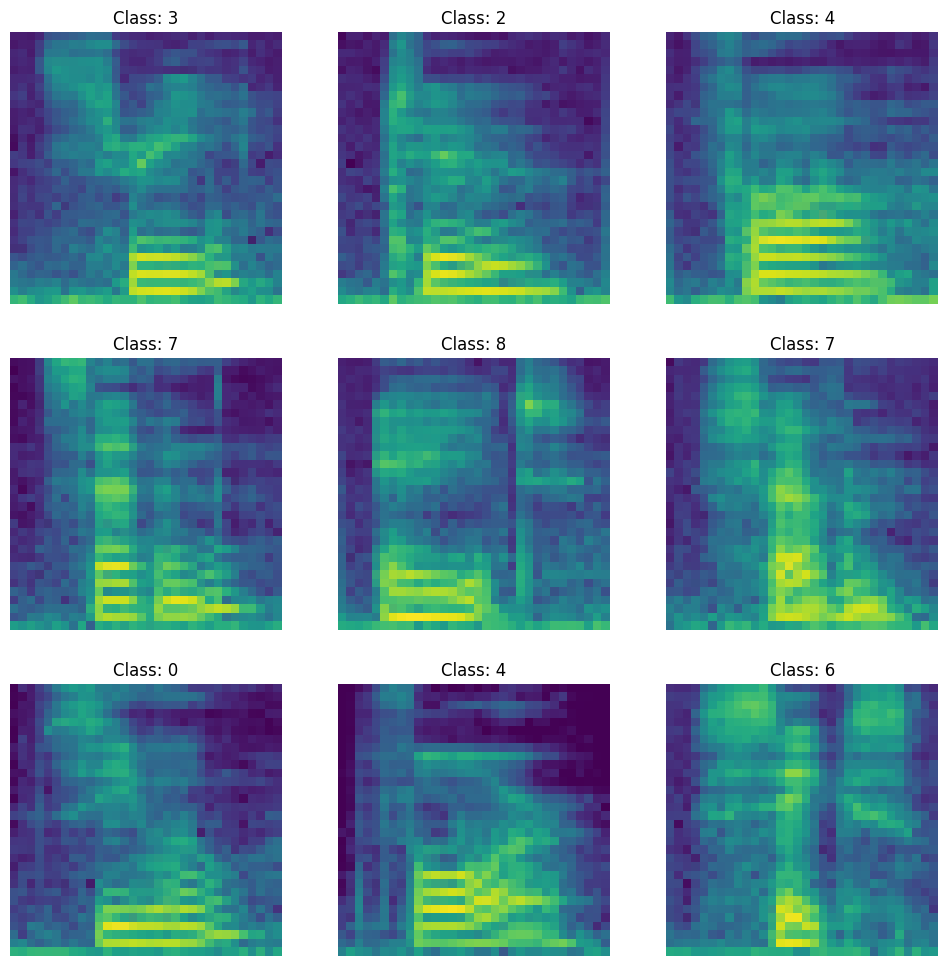

2024-09-19 17:35:16.986273: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
# Function to visualize the first batch of images
def visualize_first_batch(dataset, class_names):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(12, 12))
        for i in range(min(9, len(images))):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"Class: {class_names[labels[i]]}")
            plt.axis("off")
        plt.show()

# Visualize the first batch
visualize_first_batch(train_dataset, class_names)

In [5]:
# # Create CNN backbone for Siamese network
# def create_siamese_cnn(input_shape):
#     model = Sequential([
#         layers.Rescaling(1./255),
#         layers.Reshape(input_shape),
#         layers.Conv2D(32, (3,3), activation='relu'),
#         layers.MaxPooling2D(2,2),
#         layers.BatchNormalization(),

#         layers.Conv2D(64, (3,3), activation='relu'),
#         layers.MaxPooling2D(2,2),
#         layers.BatchNormalization(),
        
#         layers.Conv2D(128, (3,3), activation='relu'),
#         layers.MaxPooling2D(2,2),
#         layers.BatchNormalization(),
        
#         # layers.Conv2D(256, (3,3), activation='relu'),
#         # layers.MaxPooling2D(2,2),
#         # layers.BatchNormalization(),
        
#         # layers.Conv2D(512, (3,3), activation='relu'),
#         # layers.MaxPooling2D(2,2),
#         # layers.BatchNormalization(),
        
#         layers.Flatten(),
#         # layers.Dense(512, activation='relu'),
#         # layers.Dropout(0.2),

#         # layers.Dense(256, activation='relu'),
#         # layers.Dropout(0.2),
        
#         layers.Dense(128, activation='relu'),
#         layers.Dropout(0.2),
        
#         layers.Dense(64, activation='relu')
#     ])
#     # model.summary()
#     return model

# # Input for two images
# img_A_inp = layers.Input((image_size, image_size, 3), name='img_A_inp')
# img_B_inp = layers.Input((image_size, image_size, 3), name='img_B_inp')

# # Create the CNN model for both inputs
# model = create_siamese_cnn((image_size, image_size, 3))
# feature_vector_A = model(img_A_inp)
# feature_vector_B = model(img_B_inp)

# # Concatenate feature vectors and add final layers
# concat = layers.Concatenate()([feature_vector_A, feature_vector_B])
# dense = layers.Dense(32, activation='relu')(concat)
# output = layers.Dense(1, activation='sigmoid')(dense)

# # Compile the Siamese network model
# siamese_model = Model(inputs=[img_A_inp, img_B_inp], outputs=output)
# siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# siamese_model.summary()

from tensorflow.keras.applications import EfficientNetB0

def create_siamese_efficientnet(input_shape):
    # Load the pre-trained EfficientNet model
    base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    
    # Freeze the base model
    base_model.trainable = False
    
    # Add custom top layers
    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        # layers.Dense(512, activation='relu'),
        # layers.Dropout(0.2),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu')
    ])
    
    return model

# Input for two images
img_A_inp = layers.Input((image_size, image_size, 3), name='img_A_inp')
img_B_inp = layers.Input((image_size, image_size, 3), name='img_B_inp')

# Create the EfficientNet model for both inputs
model = create_siamese_efficientnet((image_size, image_size, 3))
feature_vector_A = model(img_A_inp)
feature_vector_B = model(img_B_inp)

# Concatenate feature vectors and add final layers
concat = layers.Concatenate()([feature_vector_A, feature_vector_B])
dense = layers.Dense(32, activation='relu')(concat)
output = layers.Dense(1, activation='sigmoid')(dense)

# Compile the Siamese network model
siamese_model = Model(inputs=[img_A_inp, img_B_inp], outputs=output)
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
siamese_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_A_inp           │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_B_inp           │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64)        │  4,418,659 │ img_A_inp[0][0],  │
│ (Sequential)        │                   │            │ img_B_inp[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ sequential[0][0], │
│ (Concatenate)       │                   │            │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      4,128 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         33 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,422,820 (16.87 MB)

 Trainable params: 373,249 (1.42 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [6]:
# # # Function to create pairs of images for the Siamese network
# # def make_paired_dataset(X, y):
# #     X_pairs, y_pairs = [], []

# #     tuples = [(x1, y1) for x1, y1 in zip(X, y)]

# #     for t in itertools.product(tuples, tuples):
# #         pair_A, pair_B = t
# #         img_A, label_A = t[0]
# #         img_B, label_B = t[1]

# #         new_label = int(label_A == label_B)

# #         X_pairs.append([img_A, img_B])
# #         y_pairs.append(new_label)

# #     X_pairs = np.array(X_pairs)
# #     y_pairs = np.array(y_pairs)

# #     return X_pairs, y_pairs


# import numpy as np
# import itertools

# # Function to create balanced pairs of images for the Siamese network
# def make_paired_dataset(X, y):
#     X_pairs, y_pairs = [], []

#     # Get unique class labels
#     unique_labels = np.unique(y)

#     # Group indices by class
#     class_indices = {label: np.where(y == label)[0] for label in unique_labels}

#     num_samples = len(X)
#     num_pairs = num_samples ** 2  # Total number of pairs: 400 * 400 = 160,000
#     num_same_class_pairs = num_pairs // 2  # Half will be same class
#     num_diff_class_pairs = num_pairs - num_same_class_pairs  # Other half will be different class

#     # Create pairs for same class
#     for label in unique_labels:
#         same_class_indices = class_indices[label]
#         for i, j in itertools.product(same_class_indices, repeat=2):
#             if i != j:  # Avoid pairing the same image with itself
#                 X_pairs.append([X[i], X[j]])
#                 y_pairs.append(1)  # 1 for same class
#                 if len(X_pairs) >= num_same_class_pairs:
#                     break
#         if len(X_pairs) >= num_same_class_pairs:
#             break

#     # Create pairs for different classes
#     for label_A, label_B in itertools.combinations(unique_labels, 2):
#         indices_A = class_indices[label_A]
#         indices_B = class_indices[label_B]
#         for i, j in itertools.product(indices_A, indices_B):
#             X_pairs.append([X[i], X[j]])
#             y_pairs.append(0)  # 0 for different class
#             if len(X_pairs) >= num_pairs:  # Ensure total number of pairs is num_pairs
#                 break
#         if len(X_pairs) >= num_pairs:
#             break

#     X_pairs = np.array(X_pairs)
#     y_pairs = np.array(y_pairs)

#     return X_pairs, y_pairs


In [7]:
# # Randomly sample 400 examples from the training data
X_train = np.array([img.numpy() for img, _ in train_dataset.unbatch()])
y_train = np.array([label.numpy() for _, label in train_dataset.unbatch()])

# # Sample 400 examples for creating pairs
# random_indices = np.random.choice(X_train.shape[0], 400, replace=False)
# X_train_sample, y_train_sample = X_train[random_indices], y_train[random_indices]

# # Create 200 pairs (100 positive, 100 negative)
# X_train_pairs, y_train_pairs = make_paired_dataset(X_train_sample, y_train_sample)

# # Check shapes
# X_train_pairs.shape, y_train_pairs.shape

2024-09-19 17:35:21.893101: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
# # Randomly sample 20 examples from the test data
X_test = np.array([img.numpy() for img, _ in val_dataset.unbatch()])
y_test = np.array([label.numpy() for _, label in val_dataset.unbatch()])

# random_indices = np.random.choice(X_test.shape[0], 200, replace=False)
# X_test_sample, y_test_sample = X_test[random_indices], y_test[random_indices]

# X_test_pairs, y_test_pairs = make_paired_dataset(X_test_sample, y_test_sample)

# X_test_pairs.shape, y_test_pairs.shape

In [9]:
import numpy as np
import itertools
import random

# Function to create balanced pairs for the Siamese network
def make_balanced_pairs(X, y, num_pairs_per_class=None):
    """
    Create balanced pairs for a Siamese network, with equal pairs from each class and 
    the other half from different classes.

    Parameters:
    - X: Array of input images.
    - y: Array of labels corresponding to X.
    - num_pairs_per_class: Number of pairs to create for each class.

    Returns:
    - X_pairs: Array of paired images (shape: [num_pairs, 2, height, width, channels]).
    - y_pairs: Labels for the pairs (1 for same class, 0 for different class).
    """
    X_pairs, y_pairs = [], []
    unique_labels = np.unique(y)

    # Group indices by class
    class_indices = {label: np.where(y == label)[0] for label in unique_labels}

    # Define number of pairs for same class and different class
    num_classes = len(unique_labels)
    total_same_class_pairs = num_pairs_per_class * num_classes // 2  # Half will be same class pairs
    total_diff_class_pairs = total_same_class_pairs  # Other half will be different class pairs

    # Create same-class pairs: equal number of pairs from each class
    for label in unique_labels:
        same_class_indices = class_indices[label]
        num_pairs_per_class = total_same_class_pairs // num_classes  # Equal pairs per class

        for _ in range(num_pairs_per_class):
            i, j = random.sample(list(same_class_indices), 2)  # Randomly select two different samples
            X_pairs.append([X[i], X[j]])
            y_pairs.append(1)  # Label 1 for same class

    # Create different-class pairs: between two different classes
    different_class_combinations = list(itertools.combinations(unique_labels, 2))

    for label_A, label_B in different_class_combinations:
        indices_A = class_indices[label_A]
        indices_B = class_indices[label_B]
        num_pairs_per_diff_class = total_diff_class_pairs // len(different_class_combinations)

        for _ in range(num_pairs_per_diff_class):
            i = random.choice(indices_A)
            j = random.choice(indices_B)
            X_pairs.append([X[i], X[j]])
            y_pairs.append(0)  # Label 0 for different class

    # Convert lists to numpy arrays
    X_pairs = np.array(X_pairs)
    y_pairs = np.array(y_pairs)

    return X_pairs, y_pairs

# Example usage

# Randomly sample 400 examples from the training data
random_indices_train = np.random.choice(X_train.shape[0], 1000, replace=False)
X_train_sample, y_train_sample = X_train[random_indices_train], y_train[random_indices_train]

# Create 200*200 pairs for training data (20000 total same-class pairs and 20000 total different-class pairs)
X_train_pairs, y_train_pairs = make_balanced_pairs(X_train_sample, y_train_sample, num_pairs_per_class=10000)

# Randomly sample 200 examples from the test data
random_indices_test = np.random.choice(X_test.shape[0], 200, replace=False)
X_test_sample, y_test_sample = X_test[random_indices_test], y_test[random_indices_test]

# Create pairs for testing data
X_test_pairs, y_test_pairs = make_balanced_pairs(X_test_sample, y_test_sample, num_pairs_per_class=2000)

# Check shapes
print(f"X_train_pairs shape: {X_train_pairs.shape}, y_train_pairs shape: {y_train_pairs.shape}")
print(f"X_test_pairs shape: {X_test_pairs.shape}, y_test_pairs shape: {y_test_pairs.shape}")


X_train_pairs shape: (99995, 2, 32, 32, 3), y_train_pairs shape: (99995,)
X_test_pairs shape: (19990, 2, 32, 32, 3), y_test_pairs shape: (19990,)


: 

In [ ]:

# Callbacks for early stopping and checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model_siamese.keras", monitor='val_loss', save_best_only=True, verbose=0)

# Train the Siamese model
history = siamese_model.fit(
    x=[X_train_pairs[:, 0, :, :], X_train_pairs[:, 1, :, :]],
    y=y_train_pairs,
    validation_data=([X_test_pairs[:, 0, :, :], X_test_pairs[:, 1, :, :]], y_test_pairs),
    epochs=1000,
    batch_size=8,
    callbacks=[early_stopping, checkpoint]
)

/tmp/ipykernel_12472/355184287.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'b', label='Training acc', color='red')
/tmp/ipykernel_12472/355184287.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', label='Training loss', color='red')


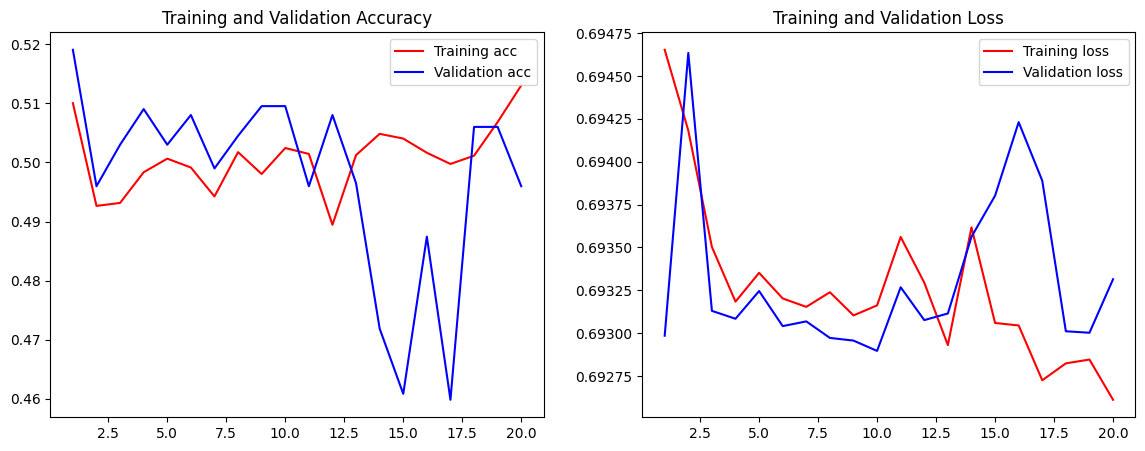

In [63]:
# Plot accuracy and loss curves
def plot_history(history):
    acc = history.history.get('accuracy', [])  # 'accuracy' is not tracked for Siamese; replace with custom metrics if used
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    if acc and val_acc:
        plt.plot(epochs, acc, 'b', label='Training acc', color='red')
        plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss', color='red')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Call the function to plot history
plot_history(history)

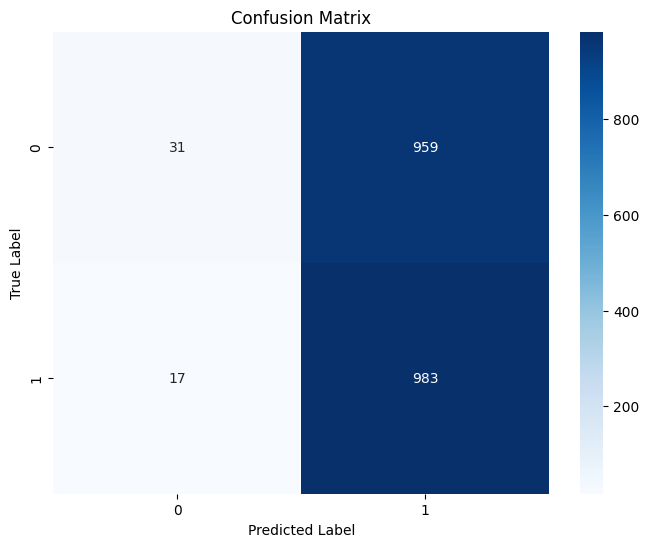

              precision    recall  f1-score   support

  Dissimilar       0.65      0.03      0.06       990
     Similar       0.51      0.98      0.67      1000

    accuracy                           0.51      1990
   macro avg       0.58      0.51      0.36      1990
weighted avg       0.58      0.51      0.37      1990



In [64]:
# Function to generate confusion matrix and classification report
def evaluate_siamese_model(model, X_test_pairs, y_test_pairs, threshold=0.5):
    # Predict similarity scores for the test pairs
    y_pred_probs = model.predict([X_test_pairs[:, 0, :, :], X_test_pairs[:, 1, :, :]], verbose=0)
    
    # Convert similarity scores to binary predictions (0 or 1) based on the threshold
    y_pred = (y_pred_probs >= threshold).astype(int)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_pairs, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print(classification_report(y_test_pairs, y_pred, target_names=["Dissimilar", "Similar"]))

# Call the function to evaluate the model
evaluate_siamese_model(siamese_model, X_test_pairs, y_test_pairs)